#  Predict Film Success 

## Importing Libraries & Loading Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

import json
import datetime
import ast

from scipy import stats

from wordcloud import WordCloud, STOPWORDS
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from IPython.display import Image, HTML

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor

import warnings
warnings.filterwarnings('ignore')

D:\Anaconda\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [2]:
df = pd.read_csv('E:/Data Science/Experience/Movies_Dataset/movies_data.csv')

## Overview the Dataset

In [3]:
df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

## Data Wrangling

First I will removing the features that are not useful to us.

In [5]:
df['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 - Written by Ørnås                                                                                                                   1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

In [6]:
df = df.drop('adult', axis=1)

In [7]:
df = df.drop(['imdb_id'], axis=1)

In [8]:
df[df['original_title'] != df['title']][['title', 'original_title']].head()

,title,original_title
28,The City of Lost Children,La Cité des Enfants Perdus
29,Shanghai Triad,摇啊摇，摇到外婆桥
32,Wings of Courage,"Guillaumet, les ailes du courage"
57,The Postman,Il postino
58,The Confessional,Le confessionnal


In [9]:
df = df.drop('original_title', axis=1)

In [10]:
df[df['revenue'] == 0].shape

(38052, 21)

I have to construct two very important features: 

1) return: the ratio of revenue to budget 

In [11]:
df['revenue'] = df['revenue'].replace(0, np.nan)

In [12]:
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
df[df['budget'].isnull()].shape

(36576, 21)

In [13]:
df['return'] = df['revenue'] / df['budget']
df[df['return'].isnull()].shape

(40085, 22)

2) year: the year in which the movie was released 

In [14]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [15]:
base_poster_url = 'http://image.tmdb.org/t/p/w185/'
df['poster_path'] = "<img src='" + base_poster_url + df['poster_path'] + "' style='height:100px;'>"

## Exploratory Data Analysis
### Overview Title Wordclouds

In [16]:
df['title'] = df['title'].astype('str')
title_corpus = ' '.join(df['title'])
df['overview'] = df['overview'].astype('str')
overview_corpus = ' '.join(df['overview'])

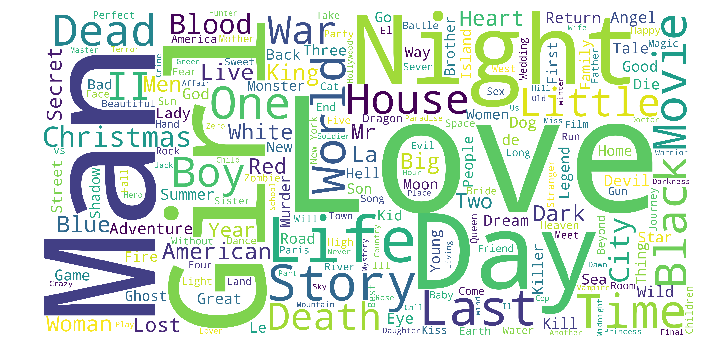

In [17]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(12,6))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

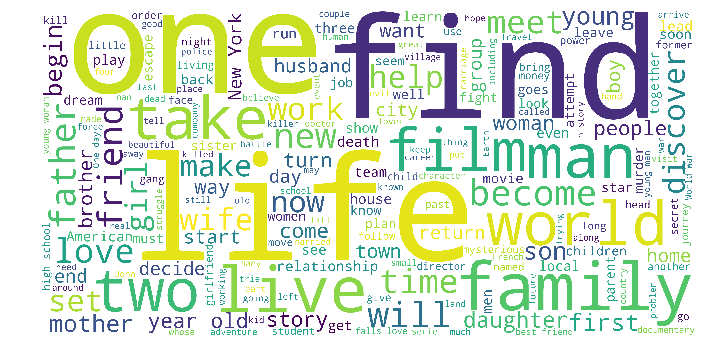

In [18]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(12,6))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

### Production Countries

In [19]:
df['production_countries'] = df['production_countries'].fillna('[]').apply(ast.literal_eval)
df['production_countries'] = df['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [20]:
s = df.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'countries'

In [21]:
con_df = df.drop('production_countries', axis=1).join(s)
con_df = pd.DataFrame(con_df['countries'].value_counts())
con_df['country'] = con_df.index
con_df.columns = ['num_movies', 'country']
con_df = con_df.reset_index().drop('index', axis=1)
con_df.head()

,num_movies,country
0,21153,United States of America
1,4094,United Kingdom
2,3940,France
3,2254,Germany
4,2169,Italy


In [22]:
con_df = con_df[con_df['country'] != 'United States of America']

In [23]:
data = [ dict(
        type = 'choropleth',
        locations = con_df['country'],
        locationmode = 'country names',
        z = con_df['num_movies'],
        text = con_df['country'],
        colorscale = [[0,'rgb(0, 255, 255)'],[1,'rgb(0, 0, 255)']],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Production Countries'),
      ) ]

layout = dict(
    title = 'Production Countries for the MovieLens Movies (Apart from US)',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

### Franchise Movies

In [24]:
df_fran = df[df['belongs_to_collection'].notnull()]
df_fran['belongs_to_collection'] = df_fran['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
df_fran = df_fran[df_fran['belongs_to_collection'].notnull()]

In [25]:
fran_pivot = df_fran.pivot_table(index='belongs_to_collection', values='revenue', aggfunc={'revenue': ['mean', 'sum', 'count']}).reset_index()

#### Highest Grossing Movie Franchises 

In [26]:
fran_pivot.sort_values('sum', ascending=False).head()

,belongs_to_collection,count,mean,sum
552,Harry Potter Collection,8,9.634209e+08,7.707367e+09
1160,Star Wars Collection,8,9.293118e+08,7.434495e+09
646,James Bond Collection,26,2.733450e+08,7.106970e+09
1317,The Fast and the Furious Collection,8,6.406373e+08,5.125099e+09
968,Pirates of the Caribbean Collection,5,9.043154e+08,4.521577e+09


#### Most Successful Movie Franchises (by Average Gross)

In [27]:
fran_pivot.sort_values('mean', ascending=False).head()

,belongs_to_collection,count,mean,sum
112,Avatar Collection,1,2.787965e+09,2.787965e+09
1245,The Avengers Collection,2,1.462481e+09,2.924962e+09
479,Frozen Collection,1,1.274219e+09,1.274219e+09
446,Finding Nemo Collection,2,9.844532e+08,1.968906e+09
1352,The Hobbit Collection,3,9.785078e+08,2.935523e+09


#### Longest Running Franchises

In [28]:
fran_pivot.sort_values('count', ascending=False).head()

,belongs_to_collection,count,mean,sum
646,James Bond Collection,26,2.733450e+08,7.106970e+09
473,Friday the 13th Collection,12,3.874155e+07,4.648985e+08
976,Pokémon Collection,11,6.348189e+07,6.983008e+08
552,Harry Potter Collection,8,9.634209e+08,7.707367e+09
540,Halloween Collection,8,3.089601e+07,2.471681e+08


### Production Companies

In [29]:
df['production_companies'] = df['production_companies'].fillna('[]').apply(ast.literal_eval)
df['production_companies'] = df['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [30]:
s = df.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'

In [31]:
com_df = df.drop('production_companies', axis=1).join(s)

In [32]:
com_sum = pd.DataFrame(com_df.groupby('companies')['revenue'].sum().sort_values(ascending=False))
com_sum.columns = ['Total']
com_mean = pd.DataFrame(com_df.groupby('companies')['revenue'].mean().sort_values(ascending=False))
com_mean.columns = ['Average']
com_count = pd.DataFrame(com_df.groupby('companies')['revenue'].count().sort_values(ascending=False))
com_count.columns = ['Number']

com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)

#### Highest Earning Production Companies

In [33]:
com_pivot.sort_values('Total', ascending=False).head()

,Total,Average,Number
Warner Bros.,6.352519e+10,1.293792e+08,491
Universal Pictures,5.525919e+10,1.193503e+08,463
Paramount Pictures,4.880819e+10,1.235650e+08,395
Twentieth Century Fox Film Corporation,4.768775e+10,1.398468e+08,341
Walt Disney Pictures,4.083727e+10,2.778046e+08,147


#### Most Succesful Production Companies

In [34]:
com_pivot[com_pivot['Number'] >= 15].sort_values('Average', ascending=False).head()

,Total,Average,Number
Pixar Animation Studios,1.118853e+10,6.215852e+08,18
Marvel Studios,1.169964e+10,6.157703e+08,19
Revolution Sun Studios,8.120339e+09,5.413559e+08,15
Lucasfilm,9.898421e+09,4.499282e+08,22
DreamWorks Animation,1.370752e+10,4.031622e+08,34


### Original Language

In [35]:
df['original_language'].drop_duplicates().shape[0]

93

In [36]:
lang_df = pd.DataFrame(df['original_language'].value_counts())
lang_df['language'] = lang_df.index
lang_df.columns = ['number', 'language']
lang_df.head()

,number,language
en,32269,en
fr,2438,fr
it,1529,it
ja,1350,ja
de,1080,de


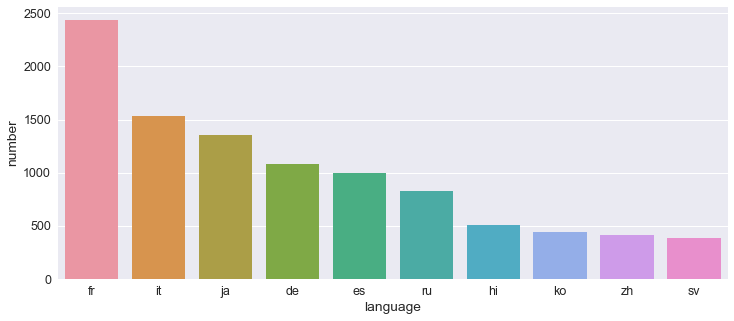

In [37]:
plt.figure(figsize=(12,5))
sns.barplot(x='language', y='number', data=lang_df.iloc[1:11])
plt.show()

### Popularity, Vote Average and Vote Count

In [38]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [39]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')

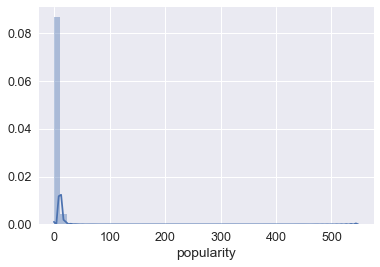

In [40]:
sns.distplot(df['popularity'].fillna(df['popularity'].median()))
plt.show()

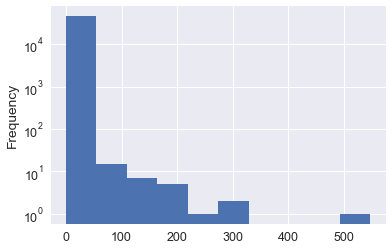

In [41]:
df['popularity'].plot(logy=True, kind='hist')

#### Most Popular Movies by Popularity Score

In [42]:
df[['title', 'popularity', 'year']].sort_values('popularity', ascending=False).head()

,title,popularity,year
30700,Minions,547.488298,2015
33356,Wonder Woman,294.337037,2017
42222,Beauty and the Beast,287.253654,2017
43644,Baby Driver,228.032744,2017
24455,Big Hero 6,213.849907,2014


#### Most Voted on Movies

In [43]:
df[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head()

,title,vote_count,year
15480,Inception,14075.0,2010
12481,The Dark Knight,12269.0,2008
14551,Avatar,12114.0,2009
17818,The Avengers,12000.0,2012
26564,Deadpool,11444.0,2016


In [44]:
df['vote_average'] = df['vote_average'].replace(0, np.nan)

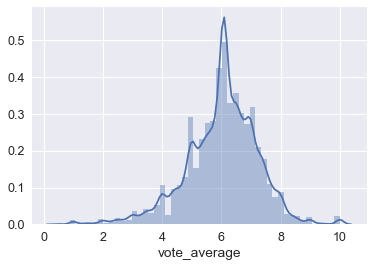

In [45]:
sns.distplot(df['vote_average'].fillna(df['vote_average'].median()))

#### Most Critically Acclaimed Movies

In [46]:
df[df['vote_count'] > 2000][['title', 'vote_average', 'vote_count' ,'year']].sort_values('vote_average', ascending=False).head()

,title,vote_average,vote_count,year
314,The Shawshank Redemption,8.5,8358.0,1994
834,The Godfather,8.5,6024.0,1972
2211,Life Is Beautiful,8.3,3643.0,1997
5481,Spirited Away,8.3,3968.0,2001
1152,One Flew Over the Cuckoo's Nest,8.3,3001.0,1975


### Movie Release Dates

In [47]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [48]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [49]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [50]:
df['day'] = df['release_date'].apply(get_day)
df['month'] = df['release_date'].apply(get_month)

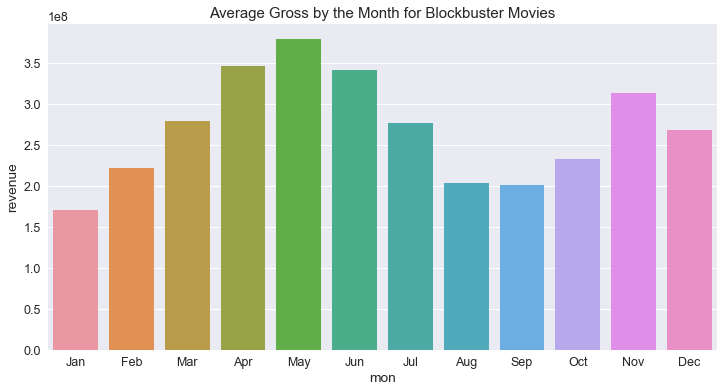

In [51]:
month_mean = pd.DataFrame(df[df['revenue'] > 1e8].groupby('month')['revenue'].mean())
month_mean['mon'] = month_mean.index
plt.figure(figsize=(12,6))
plt.title("Average Gross by the Month for Blockbuster Movies")
sns.barplot(x='mon', y='revenue', data=month_mean, order=month_order)

(0, 12)

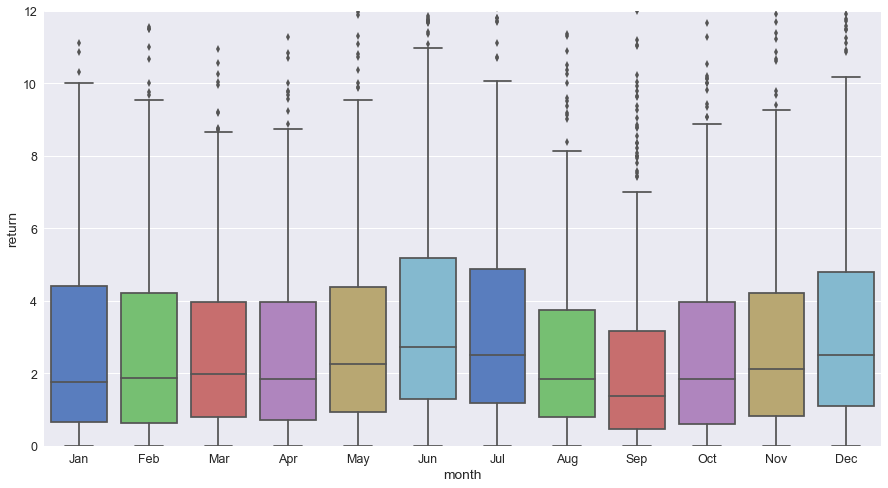

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='month', y='return', data=df[df['return'].notnull()], palette="muted", ax =ax, order=month_order)
ax.set_ylim([0, 12])

In [53]:
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [54]:
df_21 = df.copy()
df_21['year'] = df_21[df_21['year'] != 'NaT']['year'].astype(int)
df_21 = df_21[df_21['year'] >=2000]
hmap_21 = pd.pivot_table(data=df_21, index='month', columns='year', aggfunc='count', values='title')
hmap_21 = hmap_21.fillna(0)

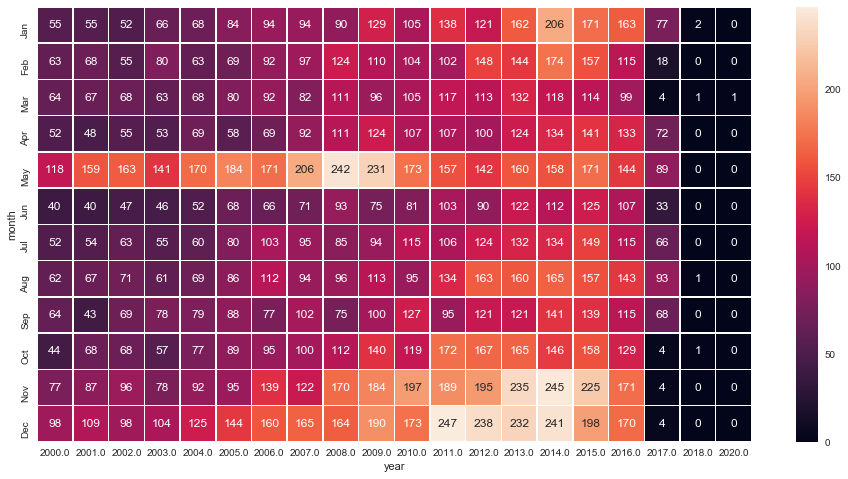

In [55]:
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(hmap_21, annot=True, linewidths=.5, ax=ax, fmt='n', yticklabels=month_order)

### Spoken Languages

In [56]:
df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(ast.literal_eval).apply(lambda x: len(x) if isinstance(x, list) else np.nan)

In [57]:
df['spoken_languages'].value_counts()

1     33736
2      5371
0      3835
3      1705
4       550
5       178
6        62
7        14
8         6
9         5
19        1
13        1
12        1
10        1
Name: spoken_languages, dtype: int64

In [58]:
df[df['spoken_languages'] >= 10][['title', 'year', 'spoken_languages']].sort_values('spoken_languages', ascending=False)

,title,year,spoken_languages
22235,Visions of Europe,2004,19
35288,The Testaments,2000,13
14093,To Each His Own Cinema,2007,12
8789,The Adventures of Picasso,1978,10


### Runtime

In [59]:
df['runtime'] = df['runtime'].astype('float')

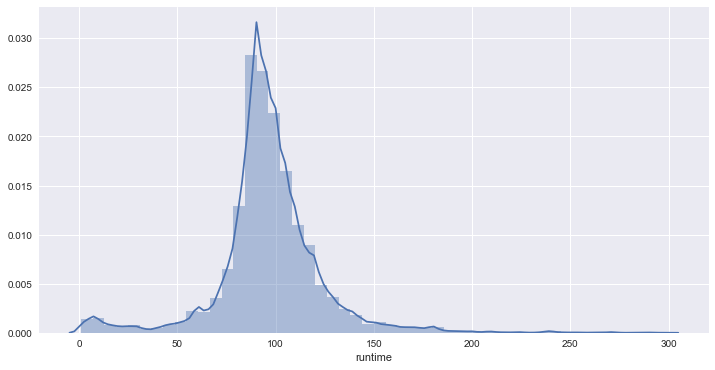

In [60]:
plt.figure(figsize=(12,6))
sns.distplot(df[(df['runtime'] < 300) & (df['runtime'] > 0)]['runtime'])

### Budget

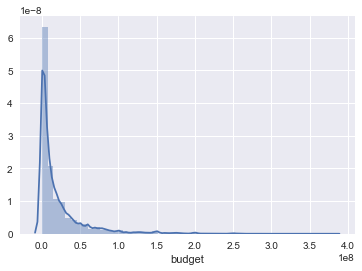

In [61]:
sns.distplot(df[df['budget'].notnull()]['budget'])

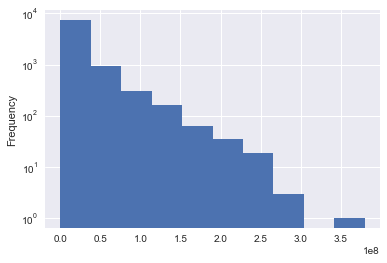

In [62]:
df['budget'].plot(logy=True, kind='hist')

### Revenue

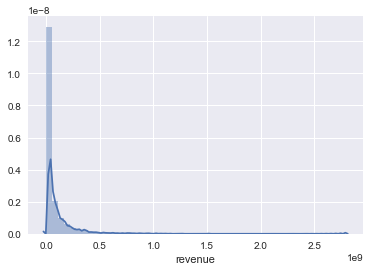

In [63]:
sns.distplot(df[df['revenue'].notnull()]['revenue'])

#### Highest Grossing Films of All Time

In [64]:
gross_top = df[['poster_path', 'title', 'budget', 'revenue', 'year']].sort_values('revenue', ascending=False).head(10)
pd.set_option('display.max_colwidth', 100)
HTML(gross_top.to_html(escape=False))

,poster_path,title,budget,revenue,year
14551,,Avatar,237000000.0,2.787965e+09,2009
26555,,Star Wars: The Force Awakens,245000000.0,2.068224e+09,2015
1639,,Titanic,200000000.0,1.845034e+09,1997
17818,,The Avengers,220000000.0,1.519558e+09,2012
25084,,Jurassic World,150000000.0,1.513529e+09,2015
28830,,Furious 7,190000000.0,1.506249e+09,2015
26558,,Avengers: Age of Ultron,280000000.0,1.405404e+09,2015
17437,,Harry Potter and the Deathly Hallows: Part 2,125000000.0,1.342000e+09,2011
22110,,Frozen,150000000.0,1.274219e+09,2013
42222,,Beauty and the Beast,160000000.0,1.262886e+09,2017


### Returns

#### Successful Movies Ranking

In [65]:
df[(df['return'].notnull()) & (df['budget'] > 5e6)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return', ascending=False).head()

,title,budget,revenue,return,year
1065,E.T. the Extra-Terrestrial,10500000.0,792965326.0,75.520507,1982
256,Star Wars,11000000.0,775398007.0,70.490728,1977
1338,Jaws,7000000.0,470654000.0,67.236286,1975
1888,The Exorcist,8000000.0,441306145.0,55.163268,1973
352,Four Weddings and a Funeral,6000000.0,254700832.0,42.450139,1994


#### Worst Movies Ranking

In [66]:
df[(df['return'].notnull()) & (df['budget'] > 5e6) & (df['revenue'] > 10000)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return').head()

,title,budget,revenue,return,year
11159,Chaos,20000000.0,10289.0,0.000514,2005
19027,5 Days of War,20000000.0,17479.0,0.000874,2011
21034,Special Forces,10000000.0,10759.0,0.001076,2011
25732,Foodfight!,65000000.0,73706.0,0.001134,2012
38388,Term Life,16500000.0,21256.0,0.001288,2016


In [67]:
df['year'] = df['year'].replace('NaT', np.nan)

In [68]:
df['year'] = df['year'].apply(clean_numeric)

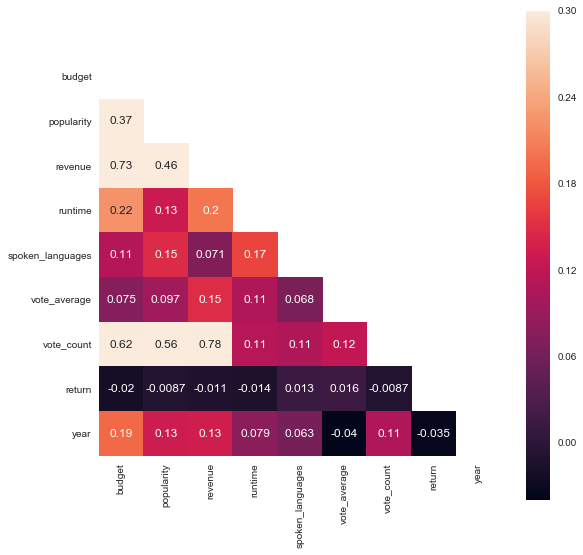

In [69]:
sns.set(font_scale=1)
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

### Genres

In [70]:
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [71]:
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [72]:
gen_df = df.drop('genres', axis=1).join(s)

In [73]:
gen_df['genre'].value_counts().shape[0]

32

In [74]:
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head()

,genre,movies
0,Drama,20265
1,Comedy,13182
2,Thriller,7624
3,Romance,6735
4,Action,6596


In [75]:
violin_genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Science Fiction', 'Fantasy', 'Animation']
violin_movies = gen_df[(gen_df['genre'].isin(violin_genres))]

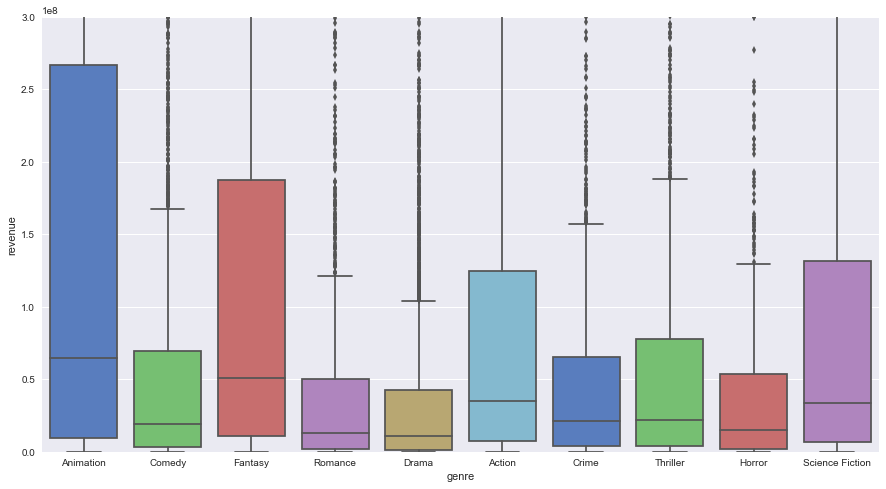

In [76]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='revenue', data=violin_movies, palette="muted", ax =ax)
ax.set_ylim([0, 3e8])
plt.show()

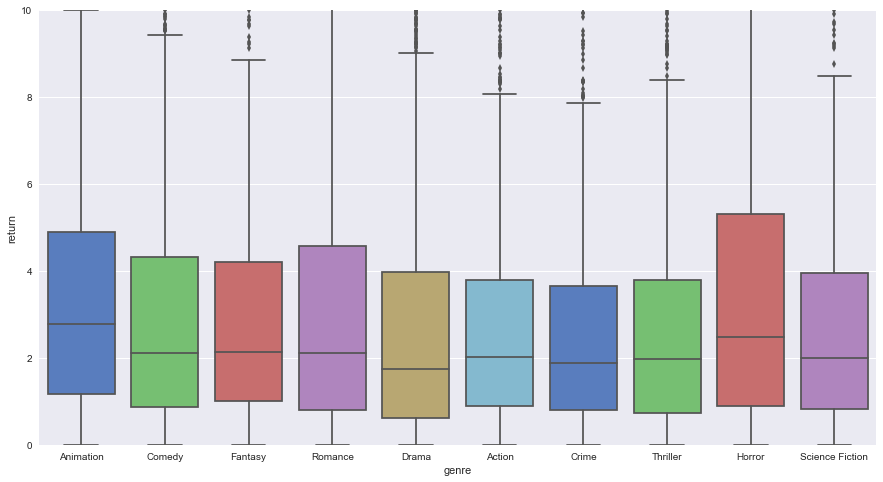

In [77]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='return', data=violin_movies, palette="muted", ax =ax)
ax.set_ylim([0, 10])
plt.show()

### Cast and Crew

In [78]:
credits_df = pd.read_csv('E:/Data Science/Experience/Movies_Dataset/credits.csv')
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender'...","[{'credit_id': '52fe4284c3a36847f8024f49', 'department': 'Directing', 'gender': 2, 'id': 7879, '...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', 'credit_id': '52fe44bfc3a36847f80a7c73', 'gender': ...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'department': 'Production', 'gender': 2, 'id': 511, '...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'credit_id': '52fe466a9251416c75077a8d', 'gender': 2...","[{'credit_id': '52fe466a9251416c75077a89', 'department': 'Directing', 'gender': 2, 'id': 26502, ...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah' Jackson"", 'credit_id': '52fe44779251416c91011aad...","[{'credit_id': '52fe44779251416c91011acb', 'department': 'Directing', 'gender': 2, 'id': 2178, '...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', 'credit_id': '52fe44959251416c75039eb9', 'gender': ...","[{'credit_id': '52fe44959251416c75039ed7', 'department': 'Sound', 'gender': 2, 'id': 37, 'job': ...",11862


In [79]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [80]:
df['id'] = df['id'].apply(convert_int)

In [81]:
df[df['id'].isnull()]

,belongs_to_collection,budget,genres,homepage,id,original_language,overview,popularity,poster_path,production_companies,...,status,tagline,title,video,vote_average,vote_count,return,year,day,month
19730,0.065736,NaN,"[Carousel Productions, Vision View Entertainment, Telescene Film Group Productions]","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso_3166_1': 'LU', 'name': 'Luxembourg'}, {'iso_3166_...",NaN,104.0,Released,NaN,<img src='http://image.tmdb.org/t/p/w185/Midnight Man' style='height:100px;'>,[],...,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,1.931659,NaN,"[Aniplex, GoHands, BROSTA TV, Mardock Scramble Production Committee, Sentai Filmworks]","[{'iso_3166_1': 'US', 'name': 'United States of America'}, {'iso_3166_1': 'JP', 'name': 'Japan'}]",NaN,68.0,Released,NaN,<img src='http://image.tmdb.org/t/p/w185/Mardock Scramble: The Third Exhaust' style='height:100p...,[],...,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,2.185485,NaN,"[Odyssey Media, Pulser Productions, Rogue State, The Cartel]","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,82.0,Released,NaN,<img src='http://image.tmdb.org/t/p/w185/Avalanche Sharks' style='height:100px;'>,[],...,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
df = df.drop([19730, 29503, 35587])

In [83]:
df['id'] = df['id'].astype('int')

In [84]:
df = df.merge(credits_df, on='id')
df.shape

(45538, 27)

In [85]:
df['cast'] = df['cast'].apply(ast.literal_eval)
df['crew'] = df['crew'].apply(ast.literal_eval)

In [86]:
df['cast_size'] = df['cast'].apply(lambda x: len(x))
df['crew_size'] = df['crew'].apply(lambda x: len(x))

In [87]:
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [88]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [89]:
df['director'] = df['crew'].apply(get_director)

In [90]:
s = df.apply(lambda x: pd.Series(x['cast']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'actor'
cast_df = df.drop('cast', axis=1).join(s)

#### Actors with the Highest Total Revenue

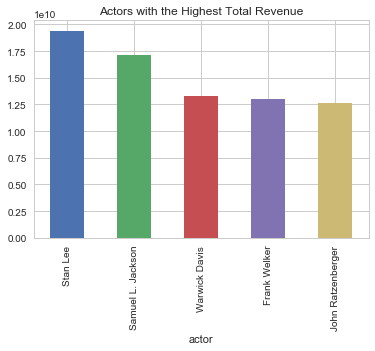

In [91]:
sns.set_style('whitegrid')
plt.title('Actors with the Highest Total Revenue')
cast_df.groupby('actor')['revenue'].sum().sort_values(ascending=False).head().plot(kind='bar')
plt.show()

#### Directors with the Highest Total Revenue

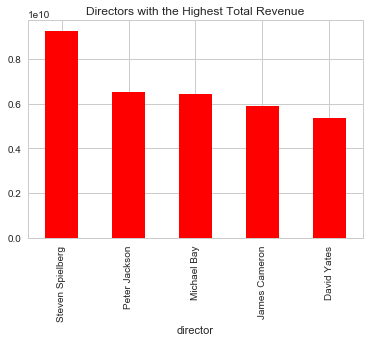

In [92]:
plt.title('Directors with the Highest Total Revenue')
df.groupby('director')['revenue'].sum().sort_values(ascending=False).head(5).plot(kind='bar', colormap='autumn')
plt.show()

In [93]:
actor_list = cast_df.groupby('actor')['revenue'].count().sort_values(ascending=False)
actor_list = list(actor_list[actor_list >= 5].index)
director_list = df.groupby('director')['revenue'].count().sort_values(ascending=False)
director_list = list(director_list[director_list >= 5].index)

#### Actors with Highest Average Revenue

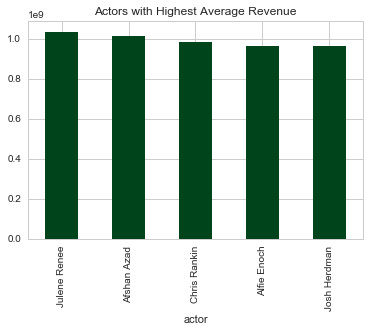

In [94]:
plt.title("Actors with Highest Average Revenue")
cast_df[cast_df['actor'].isin(actor_list)].groupby('actor')['revenue'].mean().sort_values(ascending=False).head().plot(kind='bar', colormap='Greens_r')
plt.show()

#### Directors with Highest Average Revenue

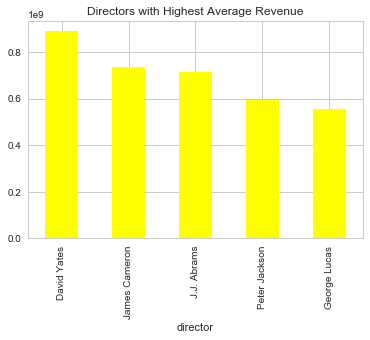

In [95]:
plt.title("Directors with Highest Average Revenue")
df[df['director'].isin(director_list)].groupby('director')['revenue'].mean().sort_values(ascending=False).head().plot(kind='bar', colormap='autumn_r')
plt.show()

## Predict Movie Revenues Using Regression Model

In [96]:
rgf = df[df['return'].notnull()]
rgf.shape

(5393, 30)

In [97]:
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'day', 'month',
       'cast', 'crew', 'cast_size', 'crew_size', 'director'],
      dtype='object')

In [98]:
rgf = rgf.drop(['id', 'overview', 'poster_path', 'release_date', 'status', 'tagline', 'video', 'return', 'crew'], axis=1)

In [99]:
s = rgf.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_rgf = rgf.drop('genres', axis=1).join(s)
genres_train = gen_rgf['genre'].drop_duplicates()

In [100]:
def feature_engineering(df):
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: 0 if x == np.nan else 1)
    for genre in genres_train:
        df['is_' + str(genre)] = df['genres'].apply(lambda x: 1 if genre in x else 0)
    df['genres'] = df['genres'].apply(lambda x: len(x))
    df['homepage'] = df['homepage'].apply(lambda x: 0 if x == np.nan else 1)
    df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
    df = df.drop('original_language', axis=1)
    df['production_companies'] = df['production_companies'].apply(lambda x: len(x))
    df['production_countries'] = df['production_countries'].apply(lambda x: len(x))
    df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
    df = df.drop('day', axis=1)
    df['is_Holiday'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Jun', 'Nov'] else 0)
    df = df.drop('month', axis=1)
    df = df.drop(['title', 'cast', 'director'], axis=1)
    df = pd.get_dummies(df, prefix='is')
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['vote_average'] = df['vote_average'].fillna(df['vote_average'].mean())
    return df

In [101]:
X, y = rgf.drop('revenue', axis=1), rgf['revenue']

In [102]:
X = feature_engineering(X)

In [103]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [104]:
X.shape

(5393, 38)

In [105]:
reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.77404748870271856

In [106]:
dummy = DummyRegressor()
dummy.fit(train_X, train_y)
dummy.score(test_X, test_y)

-0.00093441804063632006

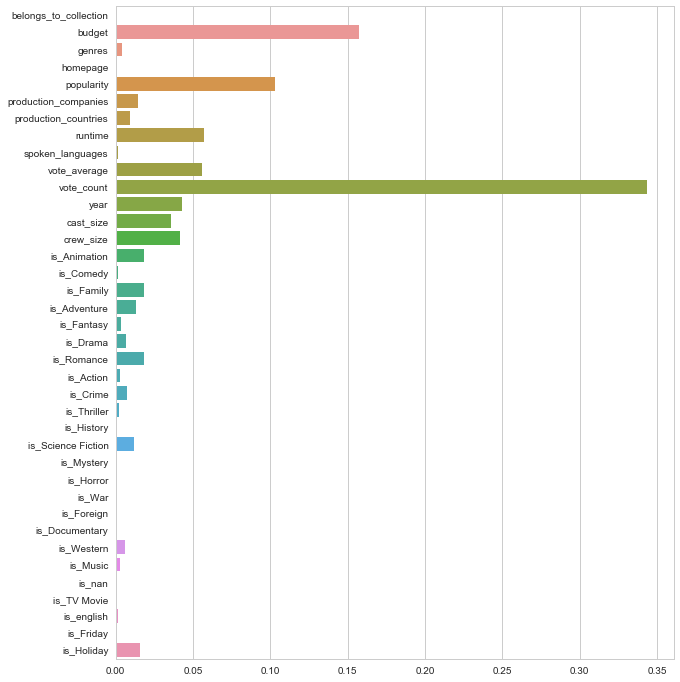

In [107]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

## Predicting Movie Sucess Using Classification Model

In [108]:
cls = df[df['return'].notnull()]
cls.shape

(5393, 30)

In [109]:
cls.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'day', 'month',
       'cast', 'crew', 'cast_size', 'crew_size', 'director'],
      dtype='object')

In [110]:
cls = cls.drop(['id', 'overview', 'poster_path', 'release_date', 'status', 'tagline', 'revenue'], axis=1)

In [111]:
cls['return'] = cls['return'].apply(lambda x: 1 if x >=1 else 0)

In [112]:
cls['return'].value_counts()

1    3784
0    1609
Name: return, dtype: int64

In [113]:
cls['belongs_to_collection'] = cls['belongs_to_collection'].fillna('').apply(lambda x: 0 if x == '' else 1)

In [114]:
s = cls.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_cls = cls.drop('genres', axis=1).join(s)

In [115]:
cls.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage',
       'original_language', 'popularity', 'production_companies',
       'production_countries', 'runtime', 'spoken_languages', 'title', 'video',
       'vote_average', 'vote_count', 'return', 'year', 'day', 'month', 'cast',
       'crew', 'cast_size', 'crew_size', 'director'],
      dtype='object')

In [116]:
def classification_engineering(df):
    for genre in genres_train:
        df['is_' + str(genre)] = df['genres'].apply(lambda x: 1 if genre in x else 0)
    df['genres'] = df['genres'].apply(lambda x: len(x))
    df = df.drop('homepage', axis=1)
    df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
    df = df.drop('original_language', axis=1)
    df['production_companies'] = df['production_companies'].apply(lambda x: len(x))
    df['production_countries'] = df['production_countries'].apply(lambda x: len(x))
    df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
    df = df.drop('day', axis=1)
    df['is_Holiday'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Jun', 'Nov'] else 0)
    df = df.drop('month', axis=1)
    df = df.drop(['title', 'cast', 'director'], axis=1)
    #df = pd.get_dummies(df, prefix='is')
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['vote_average'] = df['vote_average'].fillna(df['vote_average'].mean())
    df = df.drop('crew', axis=1)
    return df
    

In [117]:
cls = classification_engineering(cls)

In [118]:
cls.columns

Index(['belongs_to_collection', 'budget', 'genres', 'popularity',
       'production_companies', 'production_countries', 'runtime',
       'spoken_languages', 'video', 'vote_average', 'vote_count', 'return',
       'year', 'cast_size', 'crew_size', 'is_Animation', 'is_Comedy',
       'is_Family', 'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance',
       'is_Action', 'is_Crime', 'is_Thriller', 'is_History',
       'is_Science Fiction', 'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign',
       'is_Documentary', 'is_Western', 'is_Music', 'is_nan', 'is_TV Movie',
       'is_english', 'is_Friday', 'is_Holiday'],
      dtype='object')

In [119]:
X, y = cls.drop('return', axis=1), cls['return']

In [120]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y)

In [121]:
clf = GradientBoostingClassifier()
clf.fit(train_X, train_y)
clf.score(test_X, test_y)

0.79243884358784289

In [122]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(train_X, train_y)
dummy.score(test_X, test_y)

0.70200148257968864

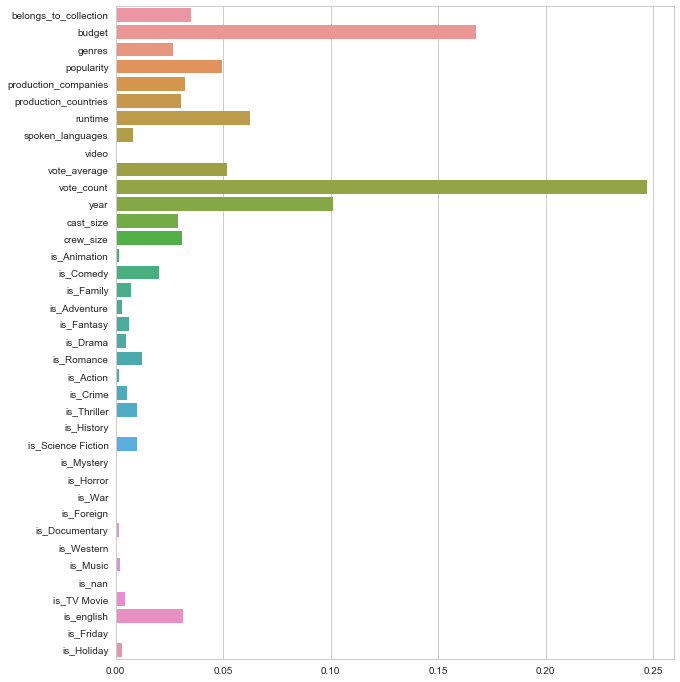

In [123]:
plt.figure(figsize=(10,12))
sns.barplot(x=clf.feature_importances_, y=X.columns)